# Attention Model
- Lag = 4 timesteps (1 hour)
- Multiheaded attention layer with 6 heads
- Sin-function as positional encoder
- Sum results of attention layer
- Flatten and concatenate with CNN
- CNN: 2-layer convolution with 16x10 resolution
- Each convolution layer with 64 filters and 3x3 window
- Maxpooling layers with 2x2 windows
- 2 dense layers at the end

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

#from utils import cyclical_encoder
#from utils import train_val_test_split
#from utils import get_model_metrics

In [2]:
#df = pd.read_csv("small_dataset.csv",parse_dates=[0])

path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file_load = 'Data_collection_entsoe/Day_ahead_dataset.csv'
df = pd.read_csv(path+file_load)

df.drop(columns=['index', 'Day ahead/System total load in MAW',
           'Day ahead/Solar in MAW',
           'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW'], inplace=True)

df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')

### Begin with cyclical encoding of the date

In [3]:
def cyclical_encoder(df,T,time_period,Date_column="Date"):
    '''
    Take in a Datetime dataframe and return the same Dataframe that now includes the two cyclical encoded columns
    '''
    if time_period == "minutes":
        df[("sin_"+time_period)] = np.sin((df.loc[:,Date_column].dt.hour*60 + df.loc[:,Date_column].dt.minute) * 2*np.pi/T)
        df[("cos_"+time_period)] = np.sin((df.loc[:,Date_column].dt.hour*60 + df.loc[:,Date_column].dt.minute) * 2*np.pi/T)
    else:
        df[("sin_"+time_period)] = np.sin(getattr(df.loc[:,Date_column].dt,time_period) * 2*np.pi/T)
        df[("cos_"+time_period)] = np.cos(getattr(df.loc[:,Date_column].dt,time_period) * 2*np.pi/T)

    return df

In [4]:
df = cyclical_encoder(df,1440,"minute")
df = cyclical_encoder(df,12,"month")
df = cyclical_encoder(df,7,"weekday")
df["Year"] = df["Date"].dt.year-2014
df = df.interpolate(method='linear')

In [5]:
df.head(5)

,Date,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW,sin_minute,cos_minute,sin_month,cos_month,sin_weekday,cos_weekday,Year
0,2014-12-31 23:00:00,0.0,8113.0,42976.0,520.0,0.000000,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,0
1,2014-12-31 23:15:00,0.0,8092.0,42540.0,517.0,0.065403,0.997859,-2.449294e-16,1.000000,0.974928,-0.222521,0
2,2014-12-31 23:30:00,0.0,8161.0,42638.0,514.0,0.130526,0.991445,-2.449294e-16,1.000000,0.974928,-0.222521,0
3,2014-12-31 23:45:00,0.0,8146.0,42483.0,515.0,0.195090,0.980785,-2.449294e-16,1.000000,0.974928,-0.222521,0
4,2015-01-01 00:00:00,0.0,8183.0,41917.0,515.0,0.000000,1.000000,5.000000e-01,0.866025,0.433884,-0.900969,1


### Train Test Split

To predict the residual load we have to predict 4 values: ["System total load in MAW","Wind Offshore in MAW","Wind Onshore in MAW","Solar in MAW"]

In [7]:
def train_val_test_split(df, target_vars, val_days, test_days):
    '''
    Split a time series data set into train, validation and test set
    INPUT:
    - df: dataset in pandas dataframe form
    - target_vars: list of the target/label variables
    - val_days: integer representing number of days to use for the validation set
    - test_days: integer representing number of days to use for the test set
    OUTPUT:
    - X_train: data set for training
    - y_train: vector of the target for the training of the model
    - X_val: data set for validation
    - y_val: vector of the target values for the validation of the model
    - X_test: data set to test the model
    - y_val: vector of the target values for testing the model
    '''

    print('The shape of the data set is: {}'.format(df.shape))

    rows_for_test = test_days*96
    rows_for_val = val_days*96

    target_vars_for_test = target_vars.copy()
    target_vars_for_test.append('Date')

    df_features = df.drop(columns=target_vars_for_test).copy()
    df_target = df[target_vars].copy()
    df_target_test = df[target_vars_for_test].copy()

    del df

    X_train = df_features.iloc[:(df_features.shape[0]-rows_for_test-rows_for_val)]
    y_train = df_target.iloc[:(df_target.shape[0]-rows_for_test-rows_for_val)]
    print('\n--------------------------------------------')
    print('The shape of the train set is: {}'.format(X_train.shape))
    print('The shape of the target variable is: {}'.format(y_train.shape))
    print('--------------------------------------------')

    X_val = df_features.iloc[X_train.shape[0]:(df_features.shape[0]-rows_for_test)]
    y_val = df_target.iloc[y_train.shape[0]:(df_target.shape[0]-rows_for_test)]
    print('\n--------------------------------------------')
    print('The shape of the validation set is: {}'.format(X_val.shape))
    print('The shape of the target variable for the validation set is: {}'.format(y_val.shape))
    print('--------------------------------------------')

    X_test = df_features.iloc[X_val.shape[0]+X_train.shape[0]:]
    y_test = df_target_test.iloc[y_val.shape[0]+X_train.shape[0]:]
    print('\n--------------------------------------------')
    print('The shape of the test set is: {}'.format(X_test.shape))
    print('The shape of the target variable for the test set is: {}'.format(y_test.shape))
    print('--------------------------------------------')

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
target_vars = ['Realised/Solar in MAW', 'Realised/Wind Onshore in MAW', 
               'Realised/System total load in MAW', 'Realised/Wind Offshore in MAW',]
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(df, target_vars, 90, 90)

The shape of the data set is: (204096, 12)

--------------------------------------------
The shape of the train set is: (186816, 7)
The shape of the target variable is: (186816, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 7)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 7)
The shape of the target variable for the test set is: (8640, 5)
--------------------------------------------


Our train test split was originally designed for a slightly different approach that is why we concatonate it again here. 

In [9]:
X_train = pd.concat([X_train,y_train],axis=1)
X_val = pd.concat([X_val,y_val],axis=1)
X_test = pd.concat([X_test,y_test.drop(columns=["Date"])],axis=1)
cols = [x for x in X_train.columns if x not in "sin_minute sin_minute \
        cos_minute sin_month cos_month sin_weekday cos_weekday Year"]

### Scaling of the features and targets

In [10]:
scaler_f = StandardScaler()
X_train.loc[:,cols] = scaler_f.fit_transform(X_train.loc[:,cols])
X_val.loc[:,cols] = scaler_f.transform(X_val.loc[:,cols])
X_test.loc[:,cols] = scaler_f.transform(X_test.loc[:,cols])

scaler_t = StandardScaler()
y_train = scaler_t.fit_transform(y_train)
y_val = scaler_t.transform(y_val)
y_test.loc[:,target_vars] = scaler_t.transform(y_test.loc[:,target_vars])

### Load feature-channels for CNN

In [11]:
def load_feature_channels(resolution, nan_value):
    
    if resolution == '16x10':
        path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
        file = f'Data_collection_weather/feature_channel_{resolution}.npy'
        feature_channel = np.load(path+file, allow_pickle=False)
    else:
        path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
        weather_file = f'Data_collection_weather/feature_channel_{resolution}.npy'
        feature_channel = np.load(path+weather_file, allow_pickle=False)
        path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
        ic_file = f'Feature_engineering/installed_capacities_{resolution}.npy'
        ic_channel = np.load(path+ic_file, allow_pickle=False)
        feature_channel = np.dstack((feature_channel, ic_channel))

    print(feature_channel.shape)
    # rearange the axis to get the examples as the first dimension for the use in tensorflow
    feature_channel = np.moveaxis(feature_channel, -1, 0)
    print(feature_channel.shape)    
    # get rid of all nans - replace them with -1
    feature_channel = np.nan_to_num(feature_channel, nan=nan_value)
    print(feature_channel.shape)

    return feature_channel

In [12]:
feature_channel = load_feature_channels('16x10', (-1))

(16, 10, 9, 204096)
(204096, 16, 10, 9)
(204096, 16, 10, 9)


In [13]:
# split feature channel

def train_val_test_split_array(feature_matrix, val_days, test_days):
    print('The shape of the feature data set is: {}'.format(feature_matrix.shape))
    #print('The shape of the target data set is: {}'.format(target_matrix.shape))

    rows_for_test = test_days*96
    rows_for_val = val_days*96

    #target_vars_for_test = target_vars.copy()
    #target_vars_for_test.append('Date')

    #df_features = df.drop(columns=target_vars_for_test).copy()
    #df_target = df[target_vars].copy()
    #df_target_test = df[target_vars_for_test].copy()

    X_train = feature_matrix[:-(rows_for_test + rows_for_val)]
    #y_train = target_matrix[105_120:-(rows_for_test + rows_for_val)]
    print('\n--------------------------------------------')
    print('The shape of the train set is: {}'.format(X_train.shape))
    #print('The shape of the target variable is: {}'.format(y_train.shape))
    print('--------------------------------------------')

    X_val = feature_matrix[X_train.shape[0]:-(rows_for_test)]
    #y_val = target_matrix[y_train.shape[0]+105_120:-(rows_for_test)]
    print('\n--------------------------------------------')
    print('The shape of the validation set is: {}'.format(X_val.shape))
    #print('The shape of the target variable for the validation set is: {}'.format(y_val.shape))
    print('--------------------------------------------')

    X_test = feature_matrix[X_val.shape[0]+X_train.shape[0]:]
    #y_test = target_matrix[y_val.shape[0]+X_train.shape[0]+105_120:]
    print('\n--------------------------------------------')
    print('The shape of the test set is: {}'.format(X_test.shape))
    #print('The shape of the target variable for the test set is: {}'.format(y_test.shape))
    print('--------------------------------------------\n')

    return X_train, X_val, X_test

In [14]:
X_train_conv, X_val_conv, X_test_conv = train_val_test_split_array(feature_channel, 90, 90)

The shape of the feature data set is: (204096, 16, 10, 9)

--------------------------------------------
The shape of the train set is: (186816, 16, 10, 9)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
--------------------------------------------



### Create Sequences out of our data:
It will look n timesteps in the past to predict value at t+1 
=> Feature shape = (n_trainings,n_steps,n_features) target_dimension = (n_trainings,4)

In [15]:
def split_sequences(features,target, n_steps):
    X, y = list(), list()
    for i in range(len(target)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix+1 > len(target):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = features.iloc[i:end_ix, :], target.iloc[end_ix,:]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
# create sequences for attention
n_steps = 4
seq_X_train,seq_y_train = split_sequences(X_train,pd.DataFrame(y_train), n_steps)
seq_X_val,seq_y_val = split_sequences(X_val,pd.DataFrame(y_val), n_steps)

n_features = seq_X_train.shape[2]

In [17]:
seq_X_train.shape

(186812, 4, 11)

### Define a function for positional encoding (copy paste from tensorflow tutorial):

In [18]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

### Create a function for an attention head:
This is of my own doing. 
- First have q,k and v go through a linear layer 
- Then have them go through attention
- Then return a weighted sum

In [19]:
def attention_head(q_in,k_in, v_in, capacity):
    Q = Dense(capacity, activation='linear')(q_in)
    K = Dense(capacity, activation='linear')(k_in)
    V = Dense(capacity, activation='linear')(v_in)
    query_value_attention  = tf.keras.layers.Attention()([Q,V,K])
#     return query_value_attention
    return tf.reduce_sum(query_value_attention, 1)    

## The model
Following this is the architecture:
- Input is devided into query, key and value. Since they are the same I could have done 1 input but for now it looks like this
- Then the input will be positional encoded
- Then it will be split up and put into n attention heads
- The output of those attention heads is concatonated and flattened
- At this stage we would feed it into the rest of our NN but in this case we just have a dense prediction layer

In [20]:
feature_channel.shape

(204096, 16, 10, 9)

In [21]:
np.isnan(seq_X_train).sum()


0

In [22]:
X_val_conv.shape

(8640, 16, 10, 9)

In [23]:
X_train_conv = X_train_conv[n_steps:]
X_val_conv = X_val_conv[n_steps:]
X_test_conv = X_test_conv[n_steps:]

In [24]:
qry = seq_X_train.astype('float32')
key = seq_X_train.astype('float32') 
values = seq_X_train.astype('float32')

q_in = Input(shape=(n_steps, n_features))
k_in = Input(shape=(n_steps, n_features))
v_in = Input(shape=(n_steps, n_features))

d_model = n_features
position = n_steps
pos_q = tf.math.add(q_in,positional_encoding(position,d_model))
pos_k = tf.math.add(k_in,positional_encoding(position,d_model))
pos_v = tf.math.add(v_in,positional_encoding(position,d_model))
  

capacity = n_features
n_heads = 6
list_heads = []
for i in range(n_heads):
    list_heads.append(attention_head(pos_q, pos_k , pos_v, capacity))

input_into_NN = tf.keras.layers.Concatenate()(list_heads)
flatten = tf.keras.layers.Flatten()(input_into_NN)

# convolutional part
encoder_input = Input(shape=(16, 10, 9))

Conv2D_1 = tf.keras.layers.Conv2D(filters=64, 
                       kernel_size=3, 
                       activation='relu', 
                       input_shape=(16,10,9))(encoder_input)
MaxPooling_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                         strides=(1,1))(Conv2D_1)
Conv2D_2 = tf.keras.layers.Conv2D(filters=64, 
                       kernel_size=3, 
                       activation='relu')(MaxPooling_1)
MaxPooling_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), 
                                         strides=(1,1))(Conv2D_2)
flatten_conv = tf.keras.layers.Flatten()(MaxPooling_2)
for_concat = Dense(66, activation='relu')(flatten_conv)

# merge the two models
final_layer = tf.keras.layers.concatenate([flatten, flatten_conv], axis=1)
Dense_1 = Dense(16, activation='relu')(final_layer)
prediction = Dense(4,activation='relu')(Dense_1)
mdl = Model(inputs=[encoder_input, q_in, k_in, v_in], outputs=[prediction])
mdl.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 11)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4, 11)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 11)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Add (TensorFlowOpLa [(None, 4, 11)]      0           input_1[0][0]                    
_______________________________________________________________________________________

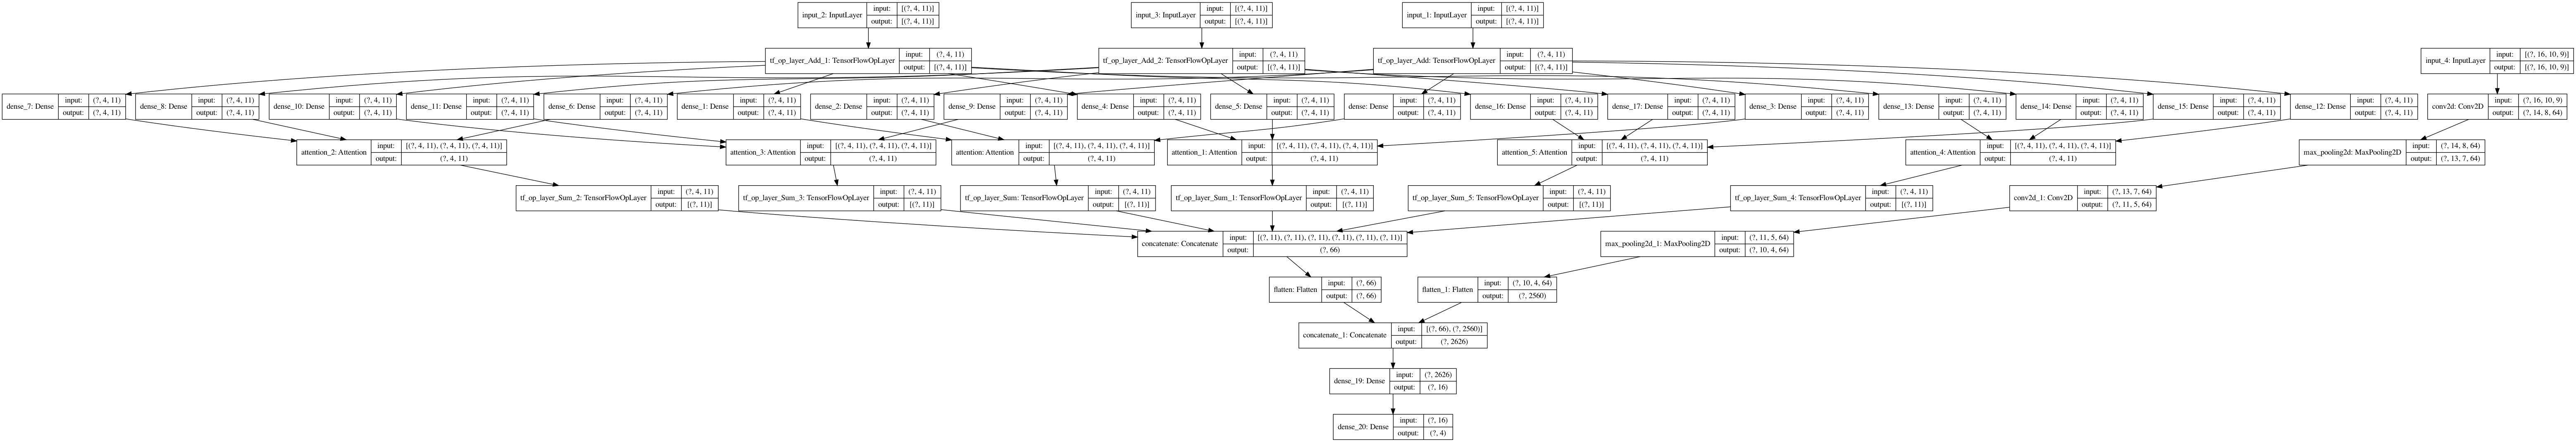

In [25]:
plot_model(mdl, "my_first_model_with_shape_info.png", show_shapes=True)


### Compile and train it

In [26]:
mdl.compile(
    optimizer = "rmsprop",
    loss = "mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [27]:
qry.shape

(186812, 4, 11)

In [28]:
X_train_conv.shape

(186812, 16, 10, 9)

In [29]:
history = mdl.fit(
    [X_train_conv, qry, key, values],seq_y_train,
    epochs=50,
    batch_size=32,
    validation_data=((X_val_conv, seq_X_val,seq_X_val,seq_X_val),seq_y_val),
    shuffle=False)

Epoch 1/50
5838/5838 [==============================] - 51s 9ms/step - loss: 0.5509 - mean_absolute_error: 0.5584 - val_loss: 0.5669 - val_mean_absolute_error: 0.5782
Epoch 2/50
5838/5838 [==============================] - 50s 9ms/step - loss: 0.3837 - mean_absolute_error: 0.4686 - val_loss: 0.5142 - val_mean_absolute_error: 0.5350
Epoch 3/50
5838/5838 [==============================] - 48s 8ms/step - loss: 0.3669 - mean_absolute_error: 0.4458 - val_loss: 0.5143 - val_mean_absolute_error: 0.5334
Epoch 4/50
5838/5838 [==============================] - 48s 8ms/step - loss: 0.3651 - mean_absolute_error: 0.4403 - val_loss: 0.5060 - val_mean_absolute_error: 0.5049
Epoch 5/50
5838/5838 [==============================] - 49s 8ms/step - loss: 0.3641 - mean_absolute_error: 0.4360 - val_loss: 0.5065 - val_mean_absolute_error: 0.5064
Epoch 6/50
5838/5838 [==============================] - 49s 8ms/step - loss: 0.3638 - mean_absolute_error: 0.4341 - val_loss: 0.5059 - val_mean_absolute_error: 0.505

Epoch 50/50
5838/5838 [==============================] - 47s 8ms/step - loss: 0.3627 - mean_absolute_error: 0.4274 - val_loss: 0.5056 - val_mean_absolute_error: 0.5028


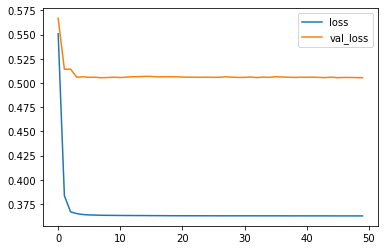

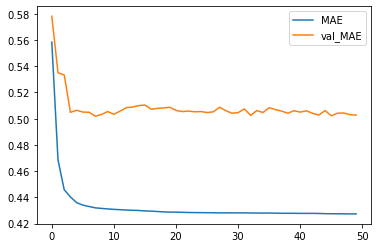

In [30]:
history.history
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()
plt.close()


history.history
plt.plot(history.history["mean_absolute_error"],label = "MAE")
plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
plt.legend()
plt.show()
plt.close()

### Evaluation

- scale the predictions back to the original dimensions
- just looking at the training error is already bad enough but test error comes at the end
- a quick comparisson below shows us that even the training error is worse than just predicting the last value
- So if the model had learned: "Forget everything else my output are just the last 4 numbers you gave me!", it would have been better

In [31]:
y_pred = mdl.predict((X_train_conv, seq_X_train, seq_X_train, seq_X_train))
y_pred_back = scaler_t.inverse_transform(y_pred)
y_train_back = scaler_t.inverse_transform(seq_y_train)
targ = ["Load","Wind off","Wind on", "Solar"]
for i in range(4):
    mae = mean_absolute_error(y_train_back[:,i], y_pred_back[:,i])
    print(f"The mean absolute error for {targ[i]} is {mae}")

The mean absolute error for Load is 2887.3076427709575
The mean absolute error for Wind off is 3307.8689155157085
The mean absolute error for Wind on is 4838.353947961386
The mean absolute error for Solar is 702.0560462676928


In [32]:
y_naive = seq_X_train[:,-1,-4:]
y_naive_back = scaler_t.inverse_transform(y_naive)
for i in range(4):
    mae = mean_absolute_error(y_train_back[:,i], y_naive_back[:,i])
    print(f"The naive mean absolute error for {targ[i]} is {mae}")

The naive mean absolute error for Load is 297.14629681176797
The naive mean absolute error for Wind off is 175.84024580862044
The naive mean absolute error for Wind on is 545.1889172001798
The naive mean absolute error for Solar is 51.62636233218423


In [34]:
from sklearn.metrics import mean_absolute_error

def get_model_metrics(y_true_with_date, y_prediction):

    y_true = np.array(y_true_with_date.iloc[:,1])
    y_pred = np.array(y_prediction)


    # get the total error and the overall MAE

    overall_mae = mean_absolute_error(y_true, y_pred)
    absolute_error = overall_mae * len(y_true)

    print('\n----------------------------------------------')
    print(f'The absolute error (total actual minus  forecast) in MW is: {round(absolute_error, 2)}')
    print('----------------------------------------------\n')

    print('\n----------------------------------------------')
    print(f'The overall mean absolute error of the model in MW is: {overall_mae}')
    print('----------------------------------------------\n')

    # get the overall mean absolute scaled error (MASE)

    naive_forecast = y_true[1:]
    y_true_for_mase = y_true[:-1]
    mae_naive = mean_absolute_error(y_true_for_mase, naive_forecast)
    overall_mae_without_first_observation = mean_absolute_error(y_true[1:], y_pred[1:])

    overall_mase = overall_mae_without_first_observation/mae_naive

    print('\n----------------------------------------------')
    print(f'The overall mean absolute scaled error of the model in MW is: {overall_mase}')
    print('Please note: to calculate the MASE, the prediction for the first observation was omitted')
    print('----------------------------------------------\n')

    # get the MAE for every day and return a dataframe and charts

    time_stamp = np.array(
                 pd.to_datetime(y_true_with_date.iloc[:,0], format='%Y-%m-%d %H:%M:%S').dt.date
                 )

    date_list = list()
    y_true_list = list()
    y_pred_list = list()

    df = pd.DataFrame({'Date': time_stamp,
                       'y_true': y_true,
                       'y_pred': y_pred})

    list_of_days = sorted(list(set(df.Date.values)))

    for day in list_of_days:
        sub_df = df.query('Date == @day')
        date_list.append(sub_df.Date.values)
        y_true_list.append(sub_df.y_true.values)
        y_pred_list.append(sub_df.y_pred.values)

    mae_list = list()
    for i, j, k in zip(y_true_list, y_pred_list, date_list):
        MAE = mean_absolute_error(i, j)
        mae_list.append(MAE)

    del df

    df = pd.DataFrame({'day':list_of_days, 'MAE': mae_list},)

    print('\n----------------------------------------------')
    print('This function also returns a dataframe with the MAE for each day')
    print('----------------------------------------------\n')

    return df

In [36]:
seq_X_test,seq_y_test = split_sequences(X_test,y_test, n_steps)

y_pred = mdl.predict((X_test_conv,seq_X_test,seq_X_test,seq_X_test))
y_pred_back = scaler_t.inverse_transform(y_pred)
y_test_back = pd.DataFrame(seq_y_test,columns=target_vars+["Date"])
y_test_back.loc[:,target_vars] = scaler_t.inverse_transform(y_test_back.loc[:,target_vars])

list_names = ["solar","wind_onshore", "load", "wind_offshore"]

for i in range(len(y_pred_back[0])):
    print("=================================")
    print(f"{list_names[i]}")
    get_model_metrics(y_test_back.iloc[:,[-1,i]],y_pred_back[:,i])
    print("=================================")

solar

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 22195071.03
----------------------------------------------


----------------------------------------------
The overall mean absolute error of the model in MW is: 2570.0638056265198
----------------------------------------------


----------------------------------------------
The overall mean absolute scaled error of the model in MW is: 6.3799629706233665
Please note: to calculate the MASE, the prediction for the first observation was omitted
----------------------------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------

wind_onshore

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 31223508.0
----------------------------------------------


----------------------------------------------
T